# ETL

In [3]:
import pandas as pd
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.functions import split, col, explode, to_date, unix_timestamp, to_timestamp, year, month, dayofmonth, dayofweek, hour, minute

In [4]:


from pyspark.sql import SparkSession
spark = (
    SparkSession
        .builder
        .appName("etl")
        .getOrCreate()
    
)

## Read data and convert to parquet

### Business dataset

In [3]:
sdf_business = spark.read.json("data/input/yelp_academic_dataset_business.json")

In [4]:
sdf_business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [5]:
def flatten_df(nested_df):
    flat_cols = [c[0] for c in nested_df.dtypes if c[1][:6] != 'struct']
    nested_cols = [c[0] for c in nested_df.dtypes if c[1][:6] == 'struct']

    flat_df = nested_df.select(flat_cols +
                               [F.col(nc+'.'+c).alias(nc+'_'+c)
                                for nc in nested_cols
                                for c in nested_df.select(nc+'.*').columns])
    return flat_df

In [6]:
sdf_business_flattened = flatten_df(sdf_business)
sdf_business_flattened.printSchema()

root
 |-- address: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- city: string (nullable = true)
 |-- is_open: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- stars: double (nullable = true)
 |-- state: string (nullable = true)
 |-- attributes_AcceptsInsurance: string (nullable = true)
 |-- attributes_AgesAllowed: string (nullable = true)
 |-- attributes_Alcohol: string (nullable = true)
 |-- attributes_Ambience: string (nullable = true)
 |-- attributes_BYOB: string (nullable = true)
 |-- attributes_BYOBCorkage: string (nullable = true)
 |-- attributes_BestNights: string (nullable = true)
 |-- attributes_BikeParking: string (nullable = true)
 |-- attributes_BusinessAcceptsBitcoin: string (nullable = true)
 |-- attributes_BusinessAcceptsCred

In [7]:
sdf_business_flattened.createOrReplaceTempView("business")

In [8]:
spark.sql("SELECT COUNT(business_id) FROM business").show()

+------------------+
|count(business_id)|
+------------------+
|            160585|
+------------------+



In [9]:
spark.sql("SELECT DISTINCT COUNT(business_id) FROM business").show()

+------------------+
|count(business_id)|
+------------------+
|            160585|
+------------------+



In [10]:
spark.sql("SELECT COUNT(DISTINCT categories) FROM business").show()

+--------------------------+
|count(DISTINCT categories)|
+--------------------------+
|                     88115|
+--------------------------+



In [11]:
spark.sql("SELECT categories, COUNT(*) AS n FROM business GROUP BY categories ORDER BY n DESC").show()

+--------------------+---+
|          categories|  n|
+--------------------+---+
|Beauty & Spas, Ha...|757|
|  Restaurants, Pizza|748|
|Hair Salons, Beau...|742|
|  Pizza, Restaurants|740|
|Beauty & Spas, Na...|734|
|Nail Salons, Beau...|712|
|  Coffee & Tea, Food|703|
|  Food, Coffee & Tea|680|
|Restaurants, Chinese|601|
|Chinese, Restaurants|588|
|Mexican, Restaurants|549|
|Restaurants, Mexican|507|
|Automotive, Auto ...|444|
|Auto Repair, Auto...|422|
|Financial Service...|390|
|Home Services, Re...|363|
|Banks & Credit Un...|347|
|Real Estate, Home...|345|
|Real Estate, Apar...|344|
|Home Services, Ap...|342|
+--------------------+---+
only showing top 20 rows



In [12]:
spark.sql("SELECT COUNT(DISTINCT city) FROM business").show()

+--------------------+
|count(DISTINCT city)|
+--------------------+
|                 836|
+--------------------+



In [13]:
spark.sql("SELECT city, COUNT(*) AS n FROM business GROUP BY city ORDER BY n DESC").show()

+---------------+-----+
|           city|    n|
+---------------+-----+
|         Austin|22416|
|       Portland|18203|
|      Vancouver|13330|
|        Atlanta|12612|
|        Orlando|10637|
|         Boston| 8263|
|       Columbus| 6634|
|        Boulder| 2542|
|      Cambridge| 2433|
|      Beaverton| 2252|
|       Richmond| 1791|
|        Burnaby| 1725|
|      Kissimmee| 1713|
|        Decatur| 1411|
|    Winter Park| 1288|
|     Somerville| 1265|
|         Quincy| 1093|
|      Brookline|  986|
|North Vancouver|  926|
|         Tigard|  916|
+---------------+-----+
only showing top 20 rows



In [14]:
spark.sql("SELECT COUNT(DISTINCT state) FROM business").show()

+---------------------+
|count(DISTINCT state)|
+---------------------+
|                   31|
+---------------------+



In [15]:
spark.sql("SELECT state, COUNT(*) AS n FROM business GROUP BY state ORDER BY n DESC").show()

+-----+-----+
|state|    n|
+-----+-----+
|   MA|36012|
|   OR|25175|
|   TX|24485|
|   FL|21907|
|   GA|18090|
|   BC|17298|
|   OH|11258|
|   CO| 3198|
|   WA| 3121|
|   CA|   13|
|   NH|    4|
|   AZ|    2|
|   VA|    2|
|   ON|    2|
|   NY|    2|
|   IL|    1|
|   MI|    1|
|   NC|    1|
|   WI|    1|
|   ME|    1|
+-----+-----+
only showing top 20 rows



### Metroplitan Areas

This dataset does not exist in the original information. The catalog of metropolitan areas is built by running a Cluster Analysis using KMeans. We know from the documentation that the dataset includes locations from 8 metropolitan areas, so a KMeans cluster with 8 clusters is estimated. Then the average latitude and loingitude is calculated for each group and looked up in google maps to find out the metropolitan area and state.

In [16]:
df_business_points = (
    spark.sql(
        """SELECT business_id, state, city, latitude, longitude 
        FROM business 
        ORDER BY state""")
    .toPandas()
)

No Null values were found.

In [17]:
df_business_points.isnull().sum()

business_id    0
state          0
city           0
latitude       0
longitude      0
dtype: int64

Estimate clusters

In [18]:
from sklearn.cluster import KMeans
k = 9
kmeans = KMeans(n_clusters=k, max_iter = 10000, random_state = 2502)
df_business_points['cluster'] = kmeans.fit_predict(df_business_points[['latitude', 'longitude']])
df_business_points['cluster'] = df_business_points.cluster.astype('category')

In [19]:
df_business_points.cluster.value_counts()

3    36021
2    28301
4    24487
5    21913
6    18094
7    17305
1    11262
0     3201
8        1
Name: cluster, dtype: int64

/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/udacity/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


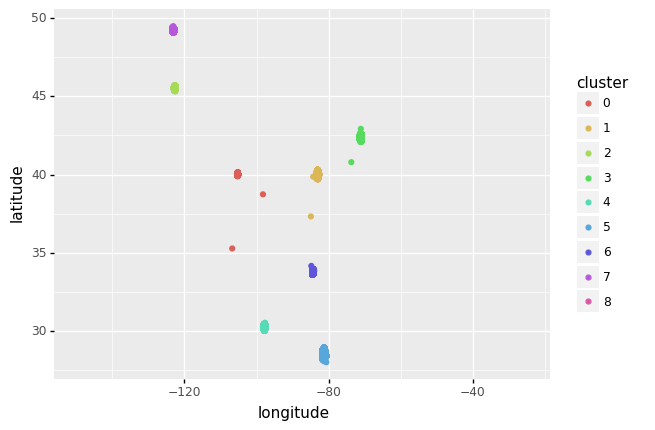

<ggplot: (303109515)>

In [20]:
from plotnine import *
(
    ggplot(df_business_points, aes(x = 'longitude', y= 'latitude', color = 'cluster')) + 
    geom_point() + 
    scale_x_continuous(limits = [-150, -25]))

In [21]:
metropolitan_areas = [
    'Denver, Colorado', 
    'Columbus, Ohio',
    'Portland, Oregon & Vancouver, Washington',
    'Cambridge, Masachusetts',
    'Austin, Texas',
    'Orlando, Florida',
    'Atlanta, Georgia',
    'Vancouver, British Columbia',
    'Cambridge, Masachusetts'
]

df_metro_area_catalog = (
    df_business_points.groupby(['cluster'])
        .mean()
        .reset_index()
        .assign(metropolitan_area = metropolitan_areas)
)
df_metro_area_catalog

,cluster,latitude,longitude,metropolitan_area
0,0,40.012371,-105.233104,"Denver, Colorado"
1,1,40.028597,-82.996501,"Columbus, Ohio"
2,2,45.514771,-122.666759,"Portland, Oregon & Vancouver, Washington"
3,3,42.368284,-71.097355,"Cambridge, Masachusetts"
4,4,30.293938,-97.768996,"Austin, Texas"
5,5,28.527385,-81.378905,"Orlando, Florida"
6,6,33.813396,-84.371422,"Atlanta, Georgia"
7,7,49.252137,-123.069710,"Vancouver, British Columbia"
8,8,42.316877,71.113271,"Cambridge, Masachusetts"


In [61]:
(
    df_business_points[['business_id','cluster']]
        .merge(df_metro_area_catalog[['cluster', 'metropolitan_area']], on = 'cluster')
        .to_parquet("data/output/metropolitan_areas/business_and_metro_area_catalog.parquet", index = False)
)

### Business data

The business data was classified by metropolitan area, so the parquet file could be partitioned by metropolitan area. It makes sense to apply this optimization to the data, as queries will be done by geographic area.

In [28]:
sdf_business_metro_area = (
    spark
        .read
        .parquet("data/output/metropolitan_areas/business_and_metro_area_catalog.parquet")
)

In [31]:
sdf_business_cleaned = sdf_business_flattened.join(sdf_business_metro_area, on = 'business_id')

In [60]:
(
    sdf_business_cleaned
        .write
        .parquet(
            "data/output/yelp_academic_dataset_business.parquet", 
            partitionBy='metropolitan_area',
        mode = 'overwrite')
)

### CheckIn dataset

In [35]:
sdf_checkin = spark.read.json("data/input/yelp_academic_dataset_checkin.json")
sdf_checkin.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)



Each entry in the dataset is a business. 
The column date is a string that contains all the checkins dates in that business_id.

In [36]:
sdf_checkin.createOrReplaceTempView('checkin')

In [37]:
spark.sql("SELECT COUNT(*) FROM checkin").show()

+--------+
|count(1)|
+--------+
|  138876|
+--------+



In [38]:
spark.sql("SELECT COUNT(DISTINCT *) FROM checkin").show()

+---------------------------------+
|count(DISTINCT business_id, date)|
+---------------------------------+
|                           138876|
+---------------------------------+



In [39]:
spark.sql("SELECT date FROM checkin LIMIT 5").toPandas()

,date
0,2017-09-03 17:13:59
1,"2010-10-08 22:21:20, 2010-11-01 21:29:14, 2010..."
2,"2010-02-26 02:06:53, 2010-02-27 08:00:09, 2010..."
3,"2014-11-03 16:35:35, 2015-01-30 18:16:03, 2015..."
4,"2010-12-15 17:10:46, 2013-12-28 00:27:54, 2015..."


In [48]:

sdf_checkin_flattened = (
    sdf_checkin
        .withColumn("date2", explode(split("date", ",")))
        .withColumn("ts", to_timestamp("date2"))
        .withColumn("date", to_date("ts"))
        .withColumn("year", year("ts"))
        .withColumn("month", month("ts"))
        .withColumn("day", dayofmonth("ts"))
        .withColumn("dayofweek", dayofweek("ts"))
        .withColumn("hour", hour("ts"))
        .withColumn("minute", minute("ts"))
)

In [49]:
sdf_checkin_flattened.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- date2: string (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)



In [50]:
sdf_checkin_flattened.show(5)

+--------------------+----------+--------------------+-------------------+----+-----+---+---------+----+------+
|         business_id|      date|               date2|                 ts|year|month|day|dayofweek|hour|minute|
+--------------------+----------+--------------------+-------------------+----+-----+---+---------+----+------+
|--0r8K_AQ4FZfLsX3...|2017-09-03| 2017-09-03 17:13:59|2017-09-03 17:13:59|2017|    9|  3|        1|  17|    13|
|--0zrn43LEaB4jUWT...|2010-10-08| 2010-10-08 22:21:20|2010-10-08 22:21:20|2010|   10|  8|        6|  22|    21|
|--0zrn43LEaB4jUWT...|2010-11-01| 2010-11-01 21:29:14|2010-11-01 21:29:14|2010|   11|  1|        2|  21|    29|
|--0zrn43LEaB4jUWT...|2010-12-23| 2010-12-23 22:55:45|2010-12-23 22:55:45|2010|   12| 23|        5|  22|    55|
|--0zrn43LEaB4jUWT...|2011-04-08| 2011-04-08 17:14:59|2011-04-08 17:14:59|2011|    4|  8|        6|  17|    14|
+--------------------+----------+--------------------+-------------------+----+-----+---+---------+----+

In [51]:
sdf_checkin_flattened.groupby('year').count().show()

+----+-------+
|year|  count|
+----+-------+
|2018|1523053|
|2015|2350194|
|2013|2274630|
|2014|2276420|
|2019|1287774|
|2020| 543039|
|2012|2174763|
|2016|2137483|
|2010| 545818|
|2011|1658762|
|2017|1838158|
|2021|  31198|
+----+-------+



In [52]:
sdf_checkin_flattened.filter(sdf_checkin_flattened.year == 2021).show()

+--------------------+----------+--------------------+-------------------+----+-----+---+---------+----+------+
|         business_id|      date|               date2|                 ts|year|month|day|dayofweek|hour|minute|
+--------------------+----------+--------------------+-------------------+----+-----+---+---------+----+------+
|--Q3mAcX9t63f7Xcb...|2021-01-05| 2021-01-05 22:21:47|2021-01-05 22:21:47|2021|    1|  5|        3|  22|    21|
|--Q3mAcX9t63f7Xcb...|2021-01-07| 2021-01-07 21:54:19|2021-01-07 21:54:19|2021|    1|  7|        5|  21|    54|
|--Q3mAcX9t63f7Xcb...|2021-01-07| 2021-01-07 22:07:11|2021-01-07 22:07:11|2021|    1|  7|        5|  22|     7|
|--Q3mAcX9t63f7Xcb...|2021-01-07| 2021-01-07 22:07:18|2021-01-07 22:07:18|2021|    1|  7|        5|  22|     7|
|--Q3mAcX9t63f7Xcb...|2021-01-09| 2021-01-09 21:46:37|2021-01-09 21:46:37|2021|    1|  9|        7|  21|    46|
|--Q3mAcX9t63f7Xcb...|2021-01-14| 2021-01-14 17:31:45|2021-01-14 17:31:45|2021|    1| 14|        5|  17|

In [58]:
sdf_checkin_flattened.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- date2: string (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)



In [62]:
sdf_checkin_cleaned =(
    sdf_checkin_flattened
        .join(sdf_business_metro_area, on = 'business_id')
)
(
    sdf_checkin_cleaned
        .write
        .partitionBy('metropolitan_area', 'year')
        .parquet("data/output/yelp_academic_dataset_checkin.parquet", mode = 'overwrite')
)

### Reviews dataset

### Tip dataset

### Users dataset

In [5]:
sdf_users = spark.read.json("data/input/yelp_academic_dataset_user.json")
sdf_users.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [6]:
sdf_users.createOrReplaceTempView('users')

In [5]:
spark.sql('SELECT COUNT(user_id) FROM users').show()

+--------------+
|count(user_id)|
+--------------+
|       2189457|
+--------------+



In [6]:
spark.sql('SELECT COUNT(*) FROM users').show()

+--------+
|count(1)|
+--------+
| 2189457|
+--------+



In [7]:
spark.sql('SELECT EXTRACT(YEAR FROM yelping_since) AS year, COUNT(*) AS n FROM users GROUP BY EXTRACT(YEAR FROM yelping_since) ORDER BY year DESC').show()

+----+------+
|year|     n|
+----+------+
|2021|  2673|
|2020| 28835|
|2019| 85451|
|2018|126518|
|2017|159533|
|2016|229356|
|2015|267516|
|2014|265124|
|2013|242864|
|2012|233502|
|2011|224158|
|2010|148041|
|2009| 94315|
|2008| 47701|
|2007| 23911|
|2006|  8218|
|2005|  1615|
|2004|   126|
+----+------+



In [7]:
sdf_users_cleaned = (
    sdf_users
        .withColumn("ts", to_timestamp("yelping_since"))
        .withColumn("year", year("ts"))
        .withColumn("month", month("ts"))
)

In [11]:
sdf_users_cleaned

DataFrame[average_stars: double, compliment_cool: bigint, compliment_cute: bigint, compliment_funny: bigint, compliment_hot: bigint, compliment_list: bigint, compliment_more: bigint, compliment_note: bigint, compliment_photos: bigint, compliment_plain: bigint, compliment_profile: bigint, compliment_writer: bigint, cool: bigint, elite: string, fans: bigint, friends: string, funny: bigint, name: string, review_count: bigint, useful: bigint, user_id: string, yelping_since: string, ts: timestamp, year: int, month: int]

In [8]:
(
    sdf_users_cleaned
        .write
        .parquet(
            "data/output/yelp_academic_dataset_user.parquet", mode = 'overwrite'
        )
)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:65027)
Traceback (most recent call last):
  File "/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/udacity/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-8588b83f7dd2>", line 2, in <module>
    sdf_users_cleaned
  File "/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/udacity/lib/python3.8/site-packages/pyspark/sql/readwriter.py", line 1249, in parquet
    self._jwrite.parquet(path)
  File "/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/udacity/lib/python3.8/site-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/udacity/lib/python3.8/site-packages/pyspark/sql/utils.py", line 111, in deco
    return f(*a, **kw)
  File "/Users/dantegruizmartinez/.pyenv/versions/3

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:65027)

In [87]:
spark.stop()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:64031)
Traceback (most recent call last):
  File "/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/udacity/lib/python3.8/site-packages/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/udacity/lib/python3.8/site-packages/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused
/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/udacity/lib/python3.8/site-packages/pyspark/context.py:460: RuntimeWarning: Unable to cleanly shutdown Spark JVM process. It is possible that the process has crashed, been killed or may also be in a zombie state.
ERROR:py4j.java_gateway:An 

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:64031)